In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
WINDOW_SIZE = 10
BATCH_SIZE = 10
SHUFFLE_BUFFER = 1000
N_EPOCHS = 30

In [3]:
time = np.arange(0, 100, 0.1)
series = 5*np.sin(time) + np.random.randn(len(time))

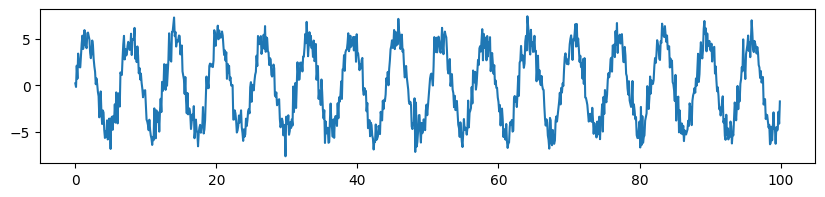

In [4]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(time, series)
plt.show()

In [35]:
def split_series(time, series, train_fraction, val_fraction, test_fraction, window_size):
    train_size = int(train_fraction*len(series))
    val_size = int(val_fraction*len(series))
    test_size = int(test_fraction*len(series))

    train_series = series[:train_size]
    val_series = series[train_size:-test_size]
    test_series = series[-(test_size + window_size):]

    train_time = time[:train_size]
    val_time = time[train_size:-test_size]
    test_time = time[-(test_size + window_size):]

    return train_series, val_series, test_series, train_time, val_time, test_time


def create_windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)


def get_dataset_size(ds):
    n = 0
    for batch in ds:
        n += batch[0].shape[0]
    return n


def print_model_size_data_size(model, train_ds, val_ds, test_ds):
    print(f'{get_dataset_size(train_ds)} training datapoints')
    print(f'{get_dataset_size(val_ds)} val datapoints')
    print(f'{get_dataset_size(test_ds)} test datapoints')
    print(f'{model.count_params()} model params')


def make_model(window_size, nunits):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, 1)),
        tf.keras.layers.LSTM(nunits, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    print_model_size_data_size(model, train_ds, val_ds, test_ds)
    return model


train_series, val_series, test_series, train_time, val_time, test_time = split_series(
    time, 
    series, 
    train_fraction=0.6, 
    val_fraction=0.2, 
    test_fraction=0.2,
    window_size=WINDOW_SIZE
)

train_ds = create_windowed_dataset(train_series, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
val_ds = create_windowed_dataset(val_series, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
test_ds = create_windowed_dataset(test_series, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

model = make_model(WINDOW_SIZE, 3)


550 training datapoints
150 val datapoints
200 test datapoints
64 model params


In [39]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1)

Epoch 1/30
     54/Unknown 7s 17ms/step - loss: 15.8810

C:\users\robet\appdata\local\programs\python\python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 15.7968 - val_loss: 10.5436
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 11.5538 - val_loss: 8.3178
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.6503 - val_loss: 7.3120
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.9021 - val_loss: 6.8585
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.2203 - val_loss: 6.4344
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.9970 - val_loss: 6.0073
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.6009 - val_loss: 5.5131
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.2073 - val_loss: 4.9692
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.8545 - val_loss: 4.3036
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.4849 - val_loss: 3.3053
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.5247 - val_loss: 2.1911
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.1537 - va

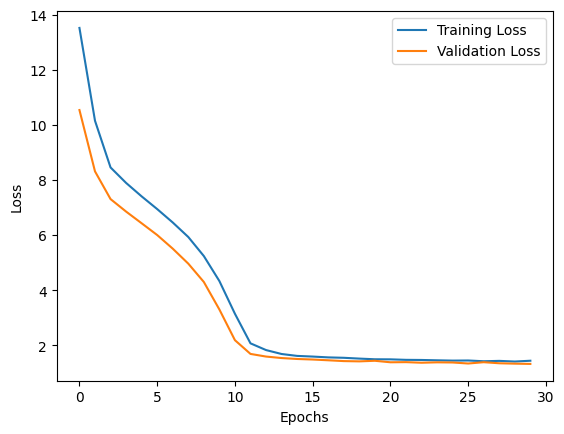

In [40]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

In [41]:
ypred = []
ytest = []
for batch in test_ds:
    inputs, targets = batch
    ypred_batch = model.predict(inputs, verbose=0)
    ypred.extend(ypred_batch.flatten())
    ytest.extend(targets.numpy().flatten())

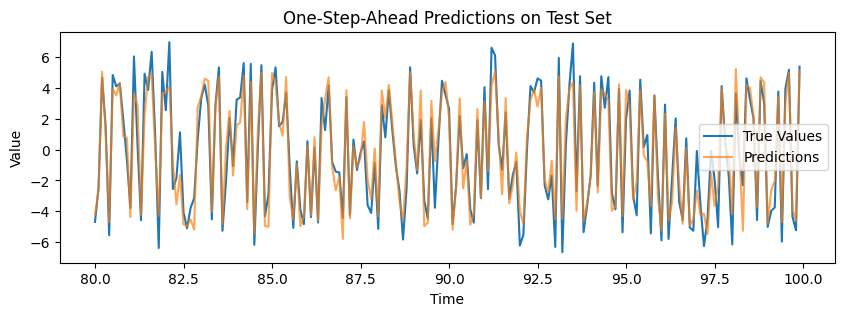

In [54]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(test_time[WINDOW_SIZE:], ytest, label='True Values')
ax.plot(test_time[WINDOW_SIZE:], ypred, label='Predictions', alpha=0.7)
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
ax.set_title('One-Step-Ahead Predictions on Test Set')
plt.show()

In [11]:
PATH = 'data/sunspots.csv'
WINDOW_SIZE = 50
BATCH_SIZE = 10

In [12]:
def load_data(path):
    df = pd.read_csv(path)
    df.columns = ['x', 'date', 'monthly_mean_sunspots']
    df = df.set_index('date')
    df = df['monthly_mean_sunspots']
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df.asfreq('ME')
    return df

df = load_data(PATH)

In [13]:
def split_train_val_test(data, test_size, val_size):
    x_train_val = df[:-test_size]
    x_test = df[-test_size:]
    x_train = x_train_val[:-val_size]
    x_val = x_train_val[-val_size:]
    return x_train, x_val, x_test

x_train, x_val, x_test = split_train_val_test(df, test_size=400, val_size=400)

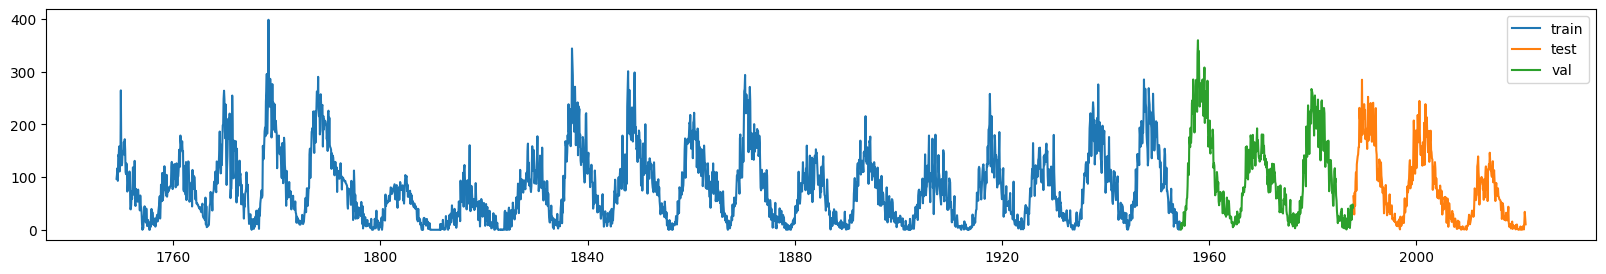

In [14]:
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(x_train, label='train')
ax.plot(x_test, label='test')
ax.plot(x_val, label='val')
ax.legend()
plt.show()

In [15]:
def make_windowed_dataset(data, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # '+ 1' to make sequences that include the last datapoint (the one to be predicted)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(20)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

train_ds = make_windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE)
val_ds = make_windowed_dataset(x_val, WINDOW_SIZE, BATCH_SIZE)
test_ds = make_windowed_dataset(x_test, WINDOW_SIZE, BATCH_SIZE)

In [16]:
model = Sequential([
    LSTM(
        10, 
        activation='relu', 
        return_sequences=False, 
        input_shape=(WINDOW_SIZE, 1)),
    Dense(1)
])

print(f'{model.count_params():,} params. on {x_train.size:,} datapoints')

491 params. on 2,465 datapoints


c:\users\robet\venvs\.deepl\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds, shuffle=True, verbose=1)

Epoch 1/10


    242/Unknown 7s 16ms/step - loss: 49.7115 - mae: 50.2026

C:\users\robet\appdata\local\programs\python\python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 49.6424 - mae: 50.1335 - val_loss: 17.6962 - val_mae: 18.1925
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 17.5214 - mae: 18.0086 - val_loss: 17.6209 - val_mae: 18.1137
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 17.5381 - mae: 18.0254 - val_loss: 17.8342 - val_mae: 18.3303
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 17.6321 - mae: 18.1194 - val_loss: 17.7055 - val_mae: 18.2029
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 17.5181 - mae: 18.0011 - val_loss: 17.5998 - val_mae: 18.0936
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 17.5565 - mae: 18.0403 - val_loss: 17.5955 - val_mae: 18.0896
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 17.4576 - mae: 17.9411 - val_loss: 17.7489 - val_mae: 18.2451
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 17.5156 - mae: 18.0005 - val_loss: 17.5715 - val_mae: 18.0658
Epoch 9/10
242/242 ━━━━━━━━

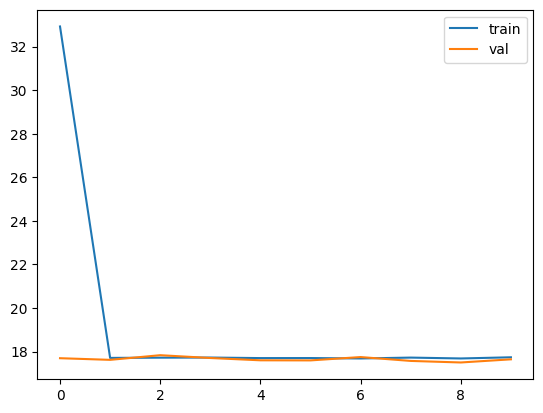

In [18]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [19]:
y_pred = model.predict(test_ds)

y_test = []
for _, y in test_ds:
    y_test.extend(y.numpy().flatten())

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [20]:
# Assuming your test set indices start where your training set ends
test_time_indices = range(len(train_series) - window_size, len(train_series) - window_size + len(true_values))


NameError: name 'window_size' is not defined

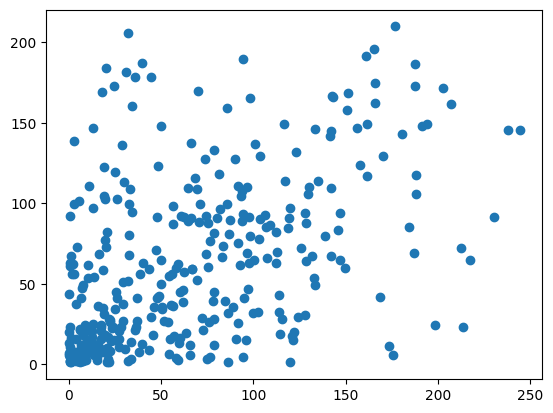

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
plt.show()